In [43]:
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Flatten, Input, Dropout, 
                          GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D,
                          BatchNormalization)
import glob
import pandas as pd
import numpy as np
from PIL import Image
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import keras
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator
import os
import magic

import tqdm
from multiprocessing import Pool, cpu_count
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, average_precision_score


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIR = '../../data/processed'

In [55]:
crawls = glob.glob('{}/media_2019*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_snopes = pd.read_csv(last_crawl)
df_snopes = df_snopes[df_snopes.label!='mixture']
df_snopes = df_snopes[~df_snopes.claim.str.contains('video',regex=False, case=False)]
df_snopes['img_filename'] = df_snopes.url_caption.apply(lambda x: '{}.ela.jpg'.format(x))

In [56]:
crawls = glob.glob('{}/reuters/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_reuters = pd.read_csv(last_crawl)
df_reuters.label = 'true'
df_reuters['img_filename'] = df_reuters.url_caption.apply(lambda x: '{}.ela.jpg'.format(x))

In [57]:
df_all = pd.concat([df_snopes, df_reuters], sort=True, axis=0)

In [58]:
img_path = '../../data/interim/imago/'

In [59]:
not_crawled = list(set(df_all.img_filename) - set(os.listdir(img_path)))

In [60]:
len(not_crawled)

65

In [61]:
not_crawled

['ps-169-pledge-allegiance-holiday-ban-controversy.ela.jpg',
 'trump-forehead-tattoo.ela.jpg',
 'cruz-castro-fake-photo.ela.jpg',
 'eyeball-tattoos.ela.jpg',
 'the-coming-ice-age.ela.jpg',
 'arctic-century-photos.ela.jpg',
 'rape-billboard-finland.ela.jpg',
 'young-aunt-bee-pin-up.ela.jpg',
 'coca-cola-kkk-trump.ela.jpg',
 'flying-lizard.ela.jpg',
 'european-jews-protesting-deportation.ela.jpg',
 'elizabeth-warren-memorabilia-shelf.ela.jpg',
 'captain-america-deemed-offensive.ela.jpg',
 'berkeley-breathed-trump-letter.ela.jpg',
 'jfk-assassination-reenactment-photo.ela.jpg',
 'weather-reporter-holly-ellenbogen-hit-by-a-stop-sign-during-storm.ela.jpg',
 'kim-jong-un-reading-fire-fury.ela.jpg',
 'are-these-women-protesting-trump.ela.jpg',
 'fox-treason-for-the-season.ela.jpg',
 'pile-bison-bones-photo.ela.jpg',
 'mosque-burn-american-flag.ela.jpg',
 'vintage-daisy-gun-ad.ela.jpg',
 'un-vehicles-in-southern-states.ela.jpg',
 'greek-customs-weapons-refugees-furniture.ela.jpg',
 'fall-folia

In [62]:
df_snopes = df_snopes[~df_snopes.img_filename.isin(not_crawled)]
df_reuters = df_reuters[~df_reuters.img_filename.isin(not_crawled)]
df_snopes = df_snopes[['img_filename', 'label']]
df_reuters = df_reuters[['img_filename', 'label']]

In [63]:
df_reuters.shape,df_snopes.shape

((395, 2), (773, 2))

In [64]:
df_snopes['label_binary'] = df_snopes.label.apply(lambda x: 1 if x == 'true' else 0)
df_reuters['label_binary'] = df_reuters.label.apply(lambda x: 1 if x == 'true' else 0)

In [65]:
def get_splits_shuffled(seed=0):
    splits = []
    df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)
    for i in range(5):        
        df_true = df[df.label == 'true']
        df_false = df[df.label == 'false'].sample(len(df_true), random_state=i+seed)
        df_all = pd.concat([df_true, df_false], sort=True, axis=0)
        
        df_train, df_test = train_test_split(df_all, test_size=100, 
                                                    random_state=i+seed, stratify=df_all.label)
        
        print(df_test.shape)

        splits.append((df_train, df_test))
    return splits

In [85]:
df_snopes[df_snopes.label == 'false'].shape

(590, 3)

In [66]:
def get_splits(seed=0):
    splits = []
    for i in range(5):
        df_snopes_true = df_snopes[df_snopes.label == 'true']
        df_train_true, df_test_true = train_test_split(df_snopes_true, test_size=50, 
                                                       random_state=i+seed)
        df_snopes_false = df_snopes[df_snopes.label == 'false'].sample(len(df_snopes_true) + len(df_reuters),
                                                                            random_state=i+seed)
        df_train_false, df_test_false = train_test_split(df_snopes_false, 
                                                         test_size=len(df_test_true), 
                                                     random_state=i+seed)
        df_test = pd.concat([df_test_true, df_test_false], sort=True, axis=0)
        df_train = pd.concat([df_train_false, df_train_true, df_reuters], sort=True, axis=0)
        
        splits.append((df_train, df_test))
    return splits

In [86]:
def get_splits_unfair(seed=0):
    splits = []
    for i in range(5):
        df_snopes_false = df_snopes[df_snopes.label == 'false'].sample(len(df_reuters),
                                                                            random_state=i+seed)
        df_all = pd.concat([df_reuters, df_snopes_false], sort=True, axis=0)
        
        df_train, df_test = train_test_split(df_all, test_size=100, 
                                                    random_state=i+seed, stratify=df_all.label)
        splits.append((df_train, df_test))
    return splits

In [67]:
splits_shuffled = get_splits_shuffled()

(100, 3)
(100, 3)
(100, 3)
(100, 3)
(100, 3)


In [68]:
splits = get_splits()

In [87]:
splits_unfair = get_splits_unfair()

In [100]:
from keras import regularizers

In [69]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [106]:
def get_model():
    model = Sequential()
    model.add(Conv2D(4,2,input_shape=(None, None, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

#     model.add(Conv2D(8,4))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(lr=0.1, decay=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, verbose=1,
                          patience=2, min_lr=0.00001)

1    422
0    422
Name: label_binary, dtype: int64
1    106
0    106
Name: label_binary, dtype: int64
1    50
0    50
Name: label_binary, dtype: int64

=============== FOLD: 0 =============================
Found 844 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/5
52/52 [==============================] - 26s 508ms/step - loss: 0.6839 - acc: 0.5721 - val_loss: 0.7565 - val_acc: 0.3942
Epoch 2/5
52/52 [==============================] - 17s 322ms/step - loss: 0.6822 - acc: 0.5553 - val_loss: 1.2546 - val_acc: 0.5102
Epoch 3/5
52/52 [==============================] - 18s 345ms/step - loss: 0.6736 - acc: 0.5850 - val_loss: 0.7887 - val_acc: 0.3827

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.
Epoch 4/5
52/52 [==============================] - 18s 355ms/step - loss: 0.6655 - acc: 0.6078 - val_loss: 0.7986 - val_acc: 0.5000
Epoch 5/5
52/52 [==============================] - 24s 462ms/ste

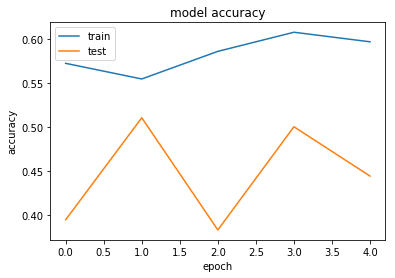

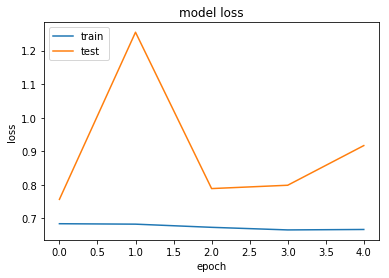

TRAIN ACCURACY: 0.560
VAL ACCURACY: 0.423
TEST ACCURACY: 0.500
Prediction dist test


False    0.8125
True     0.1875
dtype: float64

Prediction dist val


False    0.892857
True     0.107143
dtype: float64

1    422
0    422
Name: label_binary, dtype: int64
1    106
0    106
Name: label_binary, dtype: int64
1    50
0    50
Name: label_binary, dtype: int64

=============== FOLD: 1 =============================
Found 844 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/5
52/52 [==============================] - 28s 547ms/step - loss: 0.6853 - acc: 0.5589 - val_loss: 0.7184 - val_acc: 0.4615
Epoch 2/5
52/52 [==============================] - 16s 312ms/step - loss: 0.6791 - acc: 0.5810 - val_loss: 0.7326 - val_acc: 0.4949
Epoch 3/5
52/52 [==============================] - 18s 348ms/step - loss: 0.6701 - acc: 0.5877 - val_loss: 2.4995 - val_acc: 0.5204

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.
Epoch 4/5
52/52 [==============================] - 15s 295ms/step - loss: 0.6737 - acc: 0.5801 - val_loss: 0.8398 - val_acc: 0.4898
Epoch 5/5
52/52 [==============================] - 18s 343ms/ste

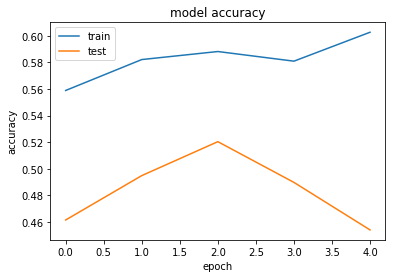

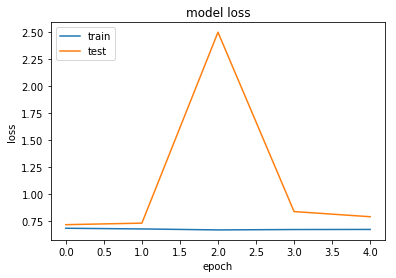

TRAIN ACCURACY: 0.607
VAL ACCURACY: 0.398
TEST ACCURACY: 0.448
Prediction dist test


True     0.635417
False    0.364583
dtype: float64

Prediction dist val


True     0.622449
False    0.377551
dtype: float64

1    422
0    422
Name: label_binary, dtype: int64
1    106
0    106
Name: label_binary, dtype: int64
1    50
0    50
Name: label_binary, dtype: int64

=============== FOLD: 2 =============================
Found 844 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/5
52/52 [==============================] - 27s 515ms/step - loss: 0.6805 - acc: 0.5685 - val_loss: 0.7287 - val_acc: 0.3894
Epoch 2/5
52/52 [==============================] - 16s 309ms/step - loss: 0.6778 - acc: 0.5741 - val_loss: 1.0228 - val_acc: 0.5102
Epoch 3/5
52/52 [==============================] - 19s 357ms/step - loss: 0.6746 - acc: 0.5885 - val_loss: 2.6704 - val_acc: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.
Epoch 4/5
52/52 [==============================] - 15s 296ms/step - loss: 0.6816 - acc: 0.5725 - val_loss: 0.9556 - val_acc: 0.4694
Epoch 5/5
52/52 [==============================] - 21s 397ms/ste

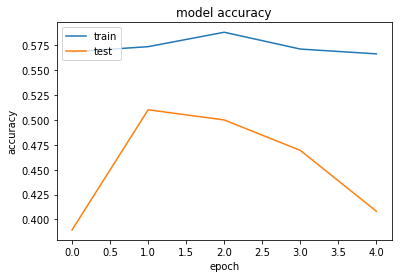

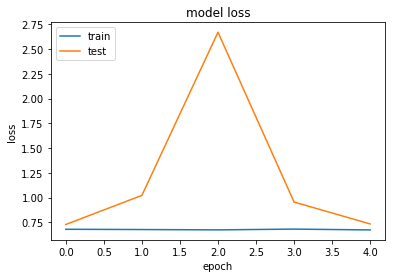

TRAIN ACCURACY: 0.600
VAL ACCURACY: 0.398
TEST ACCURACY: 0.521
Prediction dist test


False    0.5625
True     0.4375
dtype: float64

Prediction dist val


False    0.607143
True     0.392857
dtype: float64

1    422
0    422
Name: label_binary, dtype: int64
1    106
0    106
Name: label_binary, dtype: int64
1    50
0    50
Name: label_binary, dtype: int64

=============== FOLD: 3 =============================
Found 844 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/5
52/52 [==============================] - 27s 512ms/step - loss: 0.6854 - acc: 0.5637 - val_loss: 0.7215 - val_acc: 0.4519
Epoch 2/5
52/52 [==============================] - 16s 311ms/step - loss: 0.6712 - acc: 0.5809 - val_loss: 0.6939 - val_acc: 0.5204
Epoch 3/5
52/52 [==============================] - 18s 343ms/step - loss: 0.6726 - acc: 0.5809 - val_loss: 0.7926 - val_acc: 0.4643
Epoch 4/5
52/52 [==============================] - 18s 339ms/step - loss: 0.6680 - acc: 0.5861 - val_loss: 0.7995 - val_acc: 0.4949

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.
Epoch 5/5
52/52 [==============================] - 15s 284ms/ste

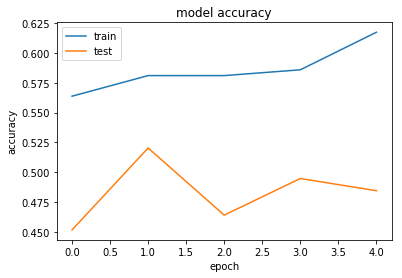

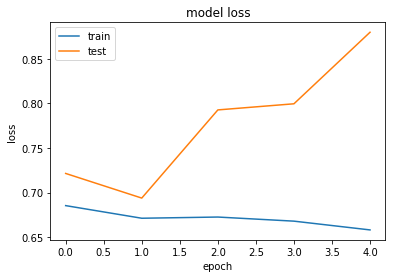

TRAIN ACCURACY: 0.511
VAL ACCURACY: 0.495
TEST ACCURACY: 0.479
Prediction dist test


True     0.979167
False    0.020833
dtype: float64

Prediction dist val


True     0.979592
False    0.020408
dtype: float64

1    422
0    422
Name: label_binary, dtype: int64
1    106
0    106
Name: label_binary, dtype: int64
1    50
0    50
Name: label_binary, dtype: int64

=============== FOLD: 4 =============================
Found 844 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/5
52/52 [==============================] - 29s 565ms/step - loss: 0.6849 - acc: 0.5805 - val_loss: 0.7320 - val_acc: 0.3702
Epoch 2/5
52/52 [==============================] - 16s 316ms/step - loss: 0.6852 - acc: 0.5469 - val_loss: 1.0340 - val_acc: 0.5153
Epoch 3/5
52/52 [==============================] - 18s 346ms/step - loss: 0.6806 - acc: 0.5833 - val_loss: 0.8972 - val_acc: 0.4133

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.
Epoch 4/5
52/52 [==============================] - 15s 289ms/step - loss: 0.6735 - acc: 0.5753 - val_loss: 0.8425 - val_acc: 0.3980
Epoch 5/5
52/52 [==============================] - 18s 345ms/ste

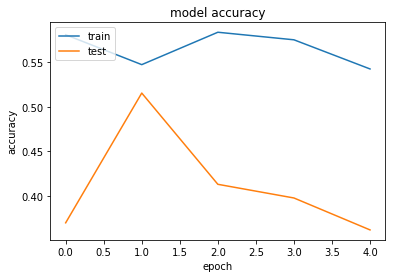

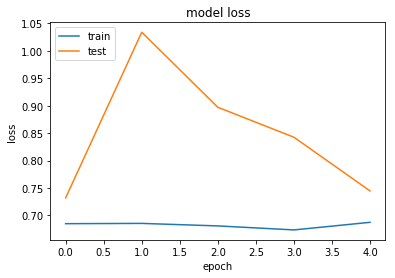

TRAIN ACCURACY: 0.594
VAL ACCURACY: 0.357
TEST ACCURACY: 0.531
Prediction dist test


True     0.520833
False    0.479167
dtype: float64

Prediction dist val


True     0.505102
False    0.494898
dtype: float64

test_accs
count   5.000000
mean    0.495833
std     0.033431
min     0.447917
25%     0.479167
50%     0.500000
75%     0.520833
max     0.531250

In [109]:
test_accs = []

for i, (train_df, test_df) in enumerate(splits_shuffled):
    train_df, val_df = train_test_split(train_df, test_size=0.2, 
                                                    random_state=1, stratify=train_df.label_binary, shuffle=True)
    
    print(train_df.label_binary.value_counts())
    print(val_df.label_binary.value_counts())
    print(test_df.label_binary.value_counts())

    print()
    print('=============== FOLD: {} ============================='.format(i))
    
    datagen=ImageDataGenerator(rescale=1./255)

    opts = {
        'directory': img_path, 
        'x_col': "img_filename", 
        'y_col': "label_binary", 
        'class_mode': "binary", 
        'batch_size': 16,
        'target_size': (100, 100)
    }

    train_generator=ImageDataGenerator(rescale=1./255).flow_from_dataframe(**opts, dataframe = train_df.reset_index())
    valid_generator=ImageDataGenerator(rescale=1./255).flow_from_dataframe(**opts, dataframe = val_df.reset_index())
    test_generator=ImageDataGenerator(rescale=1./255).flow_from_dataframe(**opts, dataframe = test_df.reset_index())
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    model = get_model()
    history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[reduce_lr],
                    epochs=5)
    plot_history(history)
    
    loss, acc = model.evaluate_generator(train_generator, steps=STEP_SIZE_TRAIN)
    print('TRAIN ACCURACY: {0:.3f}'.format(acc))
    
    loss, acc = model.evaluate_generator(valid_generator, steps=STEP_SIZE_VALID)
    print('VAL ACCURACY: {0:.3f}'.format(acc))
    
    loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
    print('TEST ACCURACY: {0:.3f}'.format(acc))
    
    test_accs.append(acc)
    
    pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST).reshape(-1)
    pred = [x > 0.5 for x in pred]    
    print('Prediction dist test')
    display(pd.Series(pred).value_counts(normalize=True))
    
    pred = model.predict_generator(valid_generator, steps=STEP_SIZE_VALID).reshape(-1)
    pred = [x > 0.5 for x in pred]    
    print('Prediction dist val')
    display(pd.Series(pred).value_counts(normalize=True))

results = pd.DataFrame()
results['test_accs'] = test_accs
results.describe()

In [108]:
results.describe()

test_accs
count   5.000000
mean    0.533333
std     0.051770
min     0.489583
25%     0.500000
50%     0.500000
75%     0.572917
max     0.604167

In [110]:
results.describe()

test_accs
count   5.000000
mean    0.495833
std     0.033431
min     0.447917
25%     0.479167
50%     0.500000
75%     0.520833
max     0.531250